<a href="https://colab.research.google.com/github/davidislip/SVM-and-MVO/blob/main/ADM_Comparison_NoteBook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integration of SVM and MVO 

A previous notebook attempted computational experiments with the following MIP formulation. 
$$
\begin{align} 
\min_{x, z, w, b} \quad & x^{\intercal}\Sigma x + \frac{1}{2}||{w}||^2 + \sum_{i=1}^N g(\xi_i)&\\ 
\textrm{s.t.} \quad & \mu^\intercal x  \geq \bar{R}, \quad \sum_i z_i \leq N \\
\quad & x_i \leq z_i \quad &\forall i = 1,2,...,N \\
              \quad & y_i^{\intercal} w + b \leq M z_i - \epsilon + \xi_i \quad & \forall i = 1,2,...,N \\
              \quad & -M(1-z_i) + \epsilon - \xi_i \leq  y_i^{\intercal} w + b \quad &\forall i = 1,2,...,N \\
              \quad & x \in \mathcal{C} \quad z \in \{0,1\}^N  \quad  w \in \mathbb{R}^m \quad \xi \geq 0& \\
\end{align} 
$$

with g as $C \xi/N$ where $C$ is a hyperparameter. It was found that directly solving the MIP above proved too computationally expensive. It would take over 24 hours to perform the ~20 years of monthly rebalancing experiments. The length of time required for a single MIP solve was also sensitive to the value of $m$. To address the computational expensiveness of solving the MIP in a  brute force fashion, I propose a penalized alternating direction method. 


## General Alternating Direction Methods 

####The description below is adapted primarily from "An Alternating Method for Cardinality-Constrained..." by Costa et. al. 

Consider the following problem:

$$
\begin{align} 
\min_{u, v} \quad & f(u, v)&\\ 
\textrm{s.t.} \quad & g(u,v) = 0, \quad h(u, v) \geq 0 \\
\quad & u \in \mathcal{U} \subseteq \mathbb{R}^{n_u}, \quad v \in \mathcal{V}  \subseteq \mathbb{R}^{n_v} \\
\end{align} 
$$

A standard alternating direction method (ADM) does the following:

1. Choose initial value $(u^0, v^0) \in \mathcal{U} \times \mathcal{V}$ and $l=0$
2. While not converged 

  2.1 Compute $u^{l+1} \in \text{argmin}\ \{  f(u,v^l): g(u, v^l) = 0, h(u,v^l) \geq 0, u \in \mathcal{U} \ \}$

  2.2 Compute $v^{l+1} \in \text{argmin}\ \{  f(u^{l+1},v): g(u^{l+1}, v) = 0, h(u^{l+1},v) \geq 0, v \in \mathcal{V} \ \}$

  2.3 $l \leftarrow l + 1$

Costa et al. then propose the use of a penalty function - variant of the ADM, whereby the coupling constraints induced by $h$ and $g$ are penalized in the objective as follows:

$$
\phi(u,v; \mu,  \rho) = f(u,v) + \sum_i \mu_i |g_i(u,v)| + \sum_j \rho_i [h_i(u,v)]^-
$$

where $\rho $ and $\mu$ denote the penalty parameters of the equality and inequality constraints. The penalized alternating direction method algorithm is nearly identical to the ADM; however, if the constraints are not satisfied at the end of the iterations, then the penalty parameters are increased, and the iteration is restarted. 

In the case of integrating support vector machines and mean-variance optimization, one formulation is as follows:

$$
\begin{align} 
\min_{x, z, w, b} \quad & x^{\intercal}\Sigma x + \frac{1}{2}||{w}||^2 &\\ 
\textrm{s.t.} \quad & \mu^\intercal x  \geq \bar{R}, \quad \sum_{i} z_i \leq N_l\\
\quad & x_i \leq z_i \quad &\forall i = 1,2,...,N \\
              \quad & y_i^{\intercal} w + b \leq M z_i - \epsilon \quad & \forall i = 1,2,...,N  \ (A)\\
              \quad & -M(1-z_i) + \epsilon \leq  y_i^{\intercal} w + b \quad &\forall i = 1,2,...,N\  (B)\\
              \quad & x \in \mathcal{C} \quad z \in \{0,1\}^N & \\
\end{align} 
$$
However, both constraints A and B can be replaced by the non-linear complementary constraint formulation:

$$(2 z_i - 1)(y_i^{\intercal} w + b) \geq \epsilon \quad i = 1,2,...,N$$

Although the constraint above is non-linear and non-convex, it decomposes into a simple linear constraint for each sub-problem when applying the alternating direction method.


Setting $u = (x, z)$ and $v = (w, b)$, the nominal problem becomes minimizing  $ f(u,v) = x^{\intercal} \Sigma x + \frac{1}{2} ||w||^2$ with 

$\mathcal{U} = \{(x,z) \in \mathbb{R}^N \times \{0,1\}^N \ | \ \mu^{\intercal} x \geq R,\  \mathbf{1}^{\intercal}x = 1,\  z_i= 1 \iff x_i > 0,\  \mathbf{1}^{\intercal} z \leq N_L \}$ 

and

 $\mathcal{V} = \{(w,b) \in \mathbb{R}^{m+1} \}$

and lastly, $h_i(u,v) = (2 z_i - 1)(y_i^{\intercal} w + b) - \epsilon$. Introducing the slack variables $\xi_i \geq 0 $ into the complementary constraint

$$(2 z_i - 1)(y_i^{\intercal} w + b) \geq \epsilon - \xi_i \quad i = 1,2,...,N$$

implies $[h_i(u,v)]^- = \xi_i(x, z, w, b)$ and that the penalty objective $\phi = x^{\intercal} \Sigma x + \frac{1}{2} ||w||^2 + \sum_{i} \mu_i \xi_i$ 

## Implementation ⌨

Given the previous iteration's SVM sub-problem results: ($w^l$, $b^l$), to obtain $x^{l+1}, z^{l+1}$ one solves $\min_{x, z}\ \{ x^{\intercal} \Sigma x  + \sum_{i} \mu_i \xi_i : \ \xi_i \geq 1 - (2z_i - 1)(y^{\intercal}w^{l} + b^l),\  (x, z) \in \mathcal{U} \ \}$

After computing $x^{l+1}, z^{l+1}$  it follows that $w^{l+1}, b^{l+1}$ are computed by solving $\min_{w, b}\ \{ \frac{1}{2} || w||^2 +  \sum_{i} \mu_i \xi_i : \ \xi_i \geq 1 - (2z^{l+1}_i - 1)(y^{\intercal}w + b),\  (w, b) \in \mathcal{V} \ \}$

In the implementation in this notebook, $\mu_i = C/N$ for a "large" C and the outer loop of incrementally increasing $\mu_i$ is not included. This is because it is possible that for a given return constraint, there may exist no portfolios with a support vector that linearly separates the assets. Therefore a significant preference for linearly separable portfolios should suffice. Furthermore, the two subproblems defined above avoid big M constraints, and are optimized more simply than the full formulation.

## Results from this notebook ⚡

* ADM method solves the min variance integrated SVM problem in approx 2.5 seconds, whereas the exact branch and bound MIP solver takes approx. 240 seconds for N = 286 assets and m = 3 factors used for the SVM decision boundary.
* The two solution methods have a max difference between the resulting portfolios of approximately 3%


In [1]:
!sudo python -m pip install gurobipy==9.1.2
import gurobipy as gp
from gurobipy import GRB
from google.colab import drive 
import math
import time
drive.mount('/content/gdrive')
pth = 'gdrive/My Drive/Colab Notebooks/'
import sys
sys.path.append(pth + 'SVM MVO/PYFILES/')
from packages import *
#from svm_mvo import *
%matplotlib inline

## Import Forecasts
forecasts = pd.read_pickle(pth +'SVM MVO/DATA/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'SVM MVO/DATA/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'SVM MVO/DATA/WRDS_ASOF.pkl')
wrds_svm_pca = pd.read_pickle(pth + 'SVM MVO/DATA/WRDS_PCA.pkl')
wrds_svm_pca['Momentum'] = wrds_svm.Momentum
## Import Monthly Prices
prices = pd.read_pickle(pth + 'SVM MVO/DATA/PRICES.pkl')

     |████████████████████████████████| 11.1 MB 4.2 MB/s 
Mounted at /content/gdrive


In [11]:
try:
  e = gp.Env(empty=True)
  #e.setParam('OutputFlag', 0)
  gurobi_licence = pd.read_csv(pth +'SVM MVO/DATA/gurobi.csv')
  e.setParam('WLSACCESSID', gurobi_licence.WLSACCESSID[0])
  e.setParam('LICENSEID', gurobi_licence.LICENSEID[0])
  e.setParam('WLSSECRET', gurobi_licence.WLSSECRET[0])
  e.start()
except: 
  !chmod 755 /content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/gurobi/grbgetkey
  !/content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/gurobi/grbgetkey 2d15bcec-464e-11ec-8a74-0242ac120003
  e = gp.Env(empty=True)
  #chmod 755 grbgetkey
  e.start()

Changed value of parameter WLSACCESSID
Changed value of parameter LICENSEID
Changed value of parameter WLSSECRET

--------------------------------------------
--------------------------------------------

info  : grbgetkey version 9.1.2, build v9.1.1rc0-30-g8af970cb
info  : Contacting Gurobi license server...
info  : License file for license ID 726787 was successfully retrieved
info  : License expires at the end of the day on 2022-01-13
info  : Saving license file...

In which directory would you like to store the Gurobi license file?
[hit Enter to store it in /opt/gurobi]: 

info  : License 726787 written to file /opt/gurobi/gurobi.lic

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-01-13
Using license file /opt/gurobi/gurobi.lic


In [12]:
%run /content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/PYFILES/svm_mvo.py

Changed value of parameter WLSACCESSID
Changed value of parameter LICENSEID
Changed value of parameter WLSSECRET

--------------------------------------------
--------------------------------------------


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-01-13
Using license file /opt/gurobi/gurobi.lic


<Figure size 432x288 with 0 Axes>

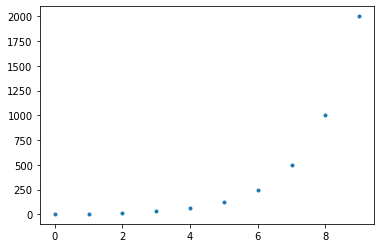

In [13]:
plt.plot(2000*0.5**(10 - np.arange(10)-1), '.')

In [15]:
mth = rets.index[0]
mth

Timestamp('2000-07-01 00:00:00')

In [110]:
#convenient function
sign = lambda a: int((a>0)) - int((a<0))

#preprocessing 
cov_, mean_ = forecasts[mth]
N = len(mean_)
cov = cov_[:N,:N] 
mean = mean_[:N,:]
tics = list(rets.columns[:N])
print("valid tickers:", tics)

#get the wharton research data for the valid tickers for the month
wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(mth, level="MonthStart")
Y = wrds_tics # Y matrix in formulation 

#Y['Momentum'] = wrds_tics.Momentum
#restrict the wharton research data to the columns of interest
Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0)) #scale the features 
Y_ = Y_[['LEV1', 'GRW1']]
cols = Y.columns.tolist() #use all the columns for this formulation
AssetLim = math.floor(N*0.8)
ret_constr = -1
soft_margin = 1000
dpi_setting = 150

valid tickers: ['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AJG', 'AKAM', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ATO', 'AVY', 'AZO', 'BA', 'BAX', 'BBY', 'BDX', 'BKNG', 'BLL', 'BMY', 'BSX', 'BWA', 'CAG', 'CAH', 'CAT', 'CCI', 'CCL', 'CDNS', 'CERN', 'CHD', 'CHRW', 'CI', 'CL', 'CLX', 'CMCSA', 'CMI', 'CMS', 'CNP', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTXS', 'CVS', 'CVX', 'D', 'DD', 'DGX', 'DHR', 'DIS', 'DISH', 'DLTR', 'DOV', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'ES', 'ETN', 'ETR', 'EVRG', 'EXC', 'EXPD', 'F', 'FAST', 'FCX', 'FDX', 'FE', 'FFIV', 'FISV', 'FLS', 'FMC', 'GD', 'GIS', 'GLW', 'GPC', 'GPS', 'GWW', 'HAL', 'HAS', 'HD', 'HES', 'HFC', 'HOG', 'HOLX', 'HON', 'HP', 'HPQ', 'HRB', 'HRL', 'HSIC', 'HSY', 'HUM', 'IBM', 'IDXX', 'IEX', 'IFF', 'INCY', 'INTC', 'INTU', 'IP', 'IPG', 'IRM', 

### Mean Variance and SVM Joint Using Alternating Directions Method Class Definition

The SVM_MVO_ADM objective does not require feasibility. Where as the other algorithm SVM_MVO_ADM_v2 does a random perturbation if it stalls at an infeasible point. 

In [111]:
MVO_ = MVO(tics, mean, cov, ret_constr, Y_, AssetLim)
SVM_ = SVM(tics, Y_ , soft_margin, non_neg = True)
SVM_MVO_Fast = SVM_MVO_ADM(MVO_, SVM_, IterLim = 10, ParamLim = 15)
SVM_MVO_Fast.MVO_.model.params.MIPGap = 0.05 
SVM_MVO_Fast.MVO_.model.params.timelimit = 60 
SVM_MVO_Fast.SVM_.model.params.timelimit = 60
SVM_MVO_Fast.MVO_.model.params.OutputFlag = 0
SVM_MVO_Fast.SVM_.model.params.OutputFlag = 0
start = time.time()
SVM_MVO_Fast.initialize_soln()
print("Initialization successful")
ws , xs, zs , xi_mvo, xi_svm, dt, objs_svm, objs_mvo = SVM_MVO_Fast.solve_ADM()
end = time.time()
print("Solution time", end - start)

Changed value of parameter MIPGap to 0.05
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter timelimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timelimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Initialization successful
Solution time 61.33656597137451


### ADM method with individual updates on the penalty parameters

In [112]:
MVO_2 = MVO(tics, mean, cov, ret_constr, Y_, AssetLim)
SVM_2 = SVM(tics, Y_ , soft_margin*np.ones_like(mean), non_neg = True)

SVM_MVO_Fast_v2 = SVM_MVO_ADM_v2(MVO_2, SVM_2, IterLim = 10, ParamLim = 15)
SVM_MVO_Fast_v2.MVO_.model.params.MIPGap = 0.05 
SVM_MVO_Fast.MVO_.model.params.timelimit = 60 
SVM_MVO_Fast_v2.SVM_.model.params.timelimit = 60
SVM_MVO_Fast_v2.MVO_.model.params.OutputFlag = 0
SVM_MVO_Fast_v2.SVM_.model.params.OutputFlag = 0
start = time.time()
SVM_MVO_Fast_v2.initialize_soln()
ws_2, xs_2, zs_2 , xi_mvo_2, xi_svm_2, dt_2, objs_svm_2, objs_mvo_2 = SVM_MVO_Fast_v2.solve_ADM()
end = time.time()
print("Solution time", end - start)

Changed value of parameter MIPGap to 0.05
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter timelimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Stalling at Infeasible Point
SVM  0.28013872687987423
MVO  0.28013742900763083
Stalling at Infeasible Point
SVM  0.006051306960750204
MVO  0.006051283062112386
Stalling at Infeasible Point
SVM  3.126222944505671e-05
MVO  3.126221156435349e-05
ADM terminated with average value of C =  5258.584829477163
Solution time 93.35381722450256


In [126]:
SVM_MVO_Fast.objective_svm[0]

0.002945049840712521

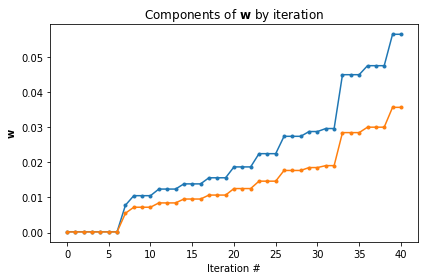

In [114]:
plt.plot(ws, ".-");
plt.xlabel("Iteration #")
plt.ylabel("$\mathbf{w}$")
plt.title("Components of $\mathbf{w}$ by iteration");
plt.tight_layout()                                                                           
plt.savefig(pth+"SVM MVO/Images/p4.png",dpi = dpi_setting)

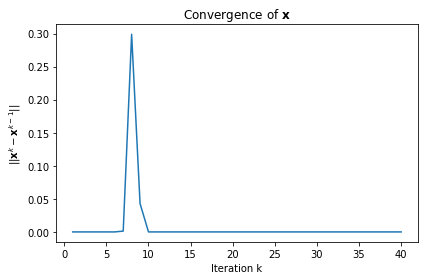

In [115]:
pd.DataFrame(xs).diff(\
                      ).abs().sum(axis = 1).iloc[1:].plot(xlabel = "Iteration k",\
                                                          ylabel = "||$\mathbf{x}^k - \mathbf{x}^{k-1}$||",\
                                                          title = "Convergence of $\mathbf{x}$");
plt.tight_layout()                                                                           
plt.savefig(pth+"SVM MVO/Images/p5.png",dpi = dpi_setting)

xi for SVM as a function of iteration number
0     0.280138
1     0.280140
2     0.280140
3     0.280138
4     0.280138
5     0.280139
6     0.280139
7     0.042277
8     0.016563
9     0.016563
10    0.016563
11    0.013585
12    0.013585
13    0.013585
14    0.011726
15    0.011726
16    0.011726
17    0.010412
18    0.010412
19    0.010412
20    0.008738
21    0.008738
22    0.008738
23    0.007220
24    0.007220
25    0.007220
26    0.005746
27    0.005746
28    0.005746
29    0.005463
30    0.005463
31    0.005328
32    0.005328
33    0.003261
34    0.003261
35    0.003261
36    0.003073
37    0.003073
38    0.003073
39    0.002523
40    0.002523
dtype: float64
xi for MVO as a function of iteration number
0     0.000000
1     0.280137
2     0.280137
3     0.280137
4     0.280137
5     0.280137
6     0.280137
7     0.249995
8     0.023869
9     0.016562
10    0.016562
11    0.016562
12    0.013585
13    0.013585
14    0.013585
15    0.011726
16    0.011726
17    0.011726
18    0.01

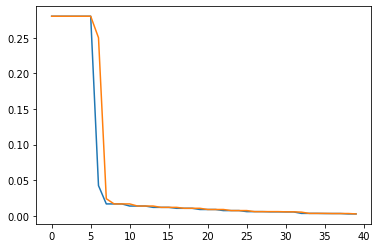

In [116]:
print("xi for SVM as a function of iteration number")
print(pd.DataFrame(xi_svm).sum(axis = 1))
print("xi for MVO as a function of iteration number")
print(pd.DataFrame(xi_mvo).sum(axis = 1))
print("These two series should converge to the same thing")
plt.plot(xi_svm[1:,:].sum(axis = 1));
plt.plot(xi_mvo[1:,:].sum(axis = 1));

In [117]:
#is there non separability
#check the last iteration xis
xi_mvo_2[-1][xi_mvo_2[-1] > 0.0001]

array([], dtype=float64)

In [118]:
#what is the asset allocation for non separable xi
xs_2[-1][xi_mvo_2[-1] > 0.0001]

array([], dtype=float64)

In [119]:
#which side of the hyperplane are the non separable points on. 
np.dot(Y_.values[xi_mvo_2[-1] > 10**(-6)], SVM_2.w.x)+ SVM_2.b.x

array([], dtype=float64)

##Exact MIP Solution with ADM Warm Start

In [120]:
#SVM with slack 
#beat 600 seconds
SVM_MVO_Slck = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, AssetLim, \
                      svm_choice = (True, True), print_var_frntr = False, indicator = True, non_neg = True)
starts = [SVM_MVO_Fast_v2.x.x, SVM_MVO_Fast_v2.z.x, SVM_MVO_Fast_v2.w.x, SVM_MVO_Fast_v2.b.x]
SVM_MVO_Slck.setModel(start = starts)
# SVM_MVO_Slck.model.params.Presolve = 2
# SVM_MVO_Slck.model.Params.ImpliedCuts = 2
SVM_MVO_Slck.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 290 rows, 1147 columns and 1716 nonzeros
Model fingerprint: 0x607e392f
Model has 41043 quadratic objective terms
Model has 572 general constraints
Variable types: 861 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [2e+00, 2e+00]
  QObjective range [6e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]

User MIP start produced solution with objective 0.0186474 (0.04s)
Loaded user MIP start with objective 0.0186474

Presolve added 746 rows and 352 columns
Presolve time: 0.01s
Presolved: 1036 rows, 1499 columns, 4356 nonzeros
Presolved model has 462 SOS constraint(s)
Presolved model has 41043 quadratic objective terms
Variable types: 1037 continuous, 462 integer (462 binary)

Root relaxation: objective 6.860883e-04, 1042 iterations, 0.02 secon

11.22816252708435

## Exact Solution without ADM

In [121]:
SVM_MVO_Slck.model.reset(clearall = 1)
SVM_MVO_Slck.setModel()
SVM_MVO_Slck.optimize()

Discarded solution information including additional information
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 290 rows, 1147 columns and 1716 nonzeros
Model fingerprint: 0x1193659e
Model has 41043 quadratic objective terms
Model has 1144 general constraints
Variable types: 861 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [2e+00, 2e+00]
  QObjective range [6e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve added 1384 rows and 990 columns
Presolve time: 0.03s
Presolved: 1674 rows, 2137 columns, 7018 nonzeros
Presolved model has 924 SOS constraint(s)
Presolved model has 41043 quadratic objective terms
Variable types: 1499 continuous, 638 integer (638 binary)
Found heuristic solution: objective 0.2121112

Root relaxation: objective 6.860883e-04, 1727 iterations, 0.05 seconds


29.18129563331604

## Comparison between exact and ADM method

### Components of $w$

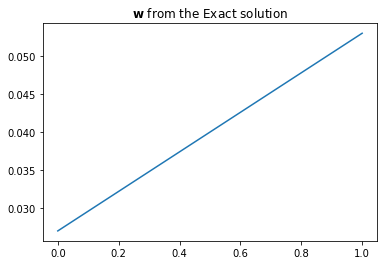

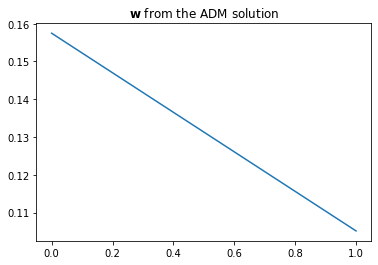

In [122]:
plt.figure(figsize = (6,4))
plt.plot(SVM_MVO_Slck.w.x)
plt.title("$\mathbf{w}$ from the Exact solution");

plt.figure(figsize = (6,4))
plt.plot(SVM_2.w.x)
plt.title("$\mathbf{w}$ from the ADM solution");


In [127]:
### quick check for any mismatch between x > 0 and z = 1
# MVO_.x.x[(MVO_.x.x > 10**(-6)).astype(int) - MVO_.z.x > 0]

### Portfolio Comparison between exact and ADM method

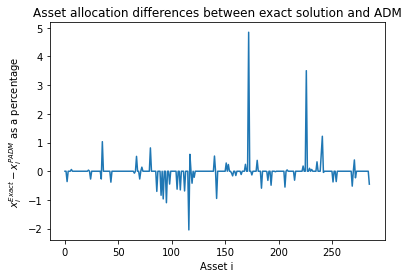

In [128]:
#plt.plot(MVO_.x.x)
plt.plot(100*(SVM_MVO_Slck.x.x - MVO_.x.x))
plt.xlabel("Asset i")
plt.ylabel("$x^{{Exact}}_i - x^{{PADM}}_i$ as a percentage");
plt.title("Asset allocation differences between exact solution and ADM");

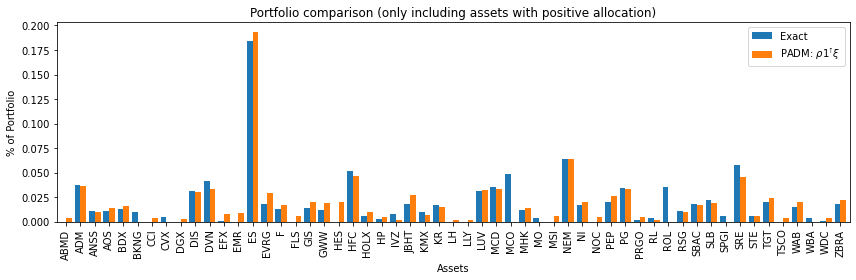

In [129]:
out = pd.concat([SVM_MVO_Slck.get_results(), SVM_MVO_Fast.get_results()], axis = 0)
out[out.columns[(out > 0.001).any(axis = 0)]].transpose()[:-2].plot.bar(title = 'Portfolio comparison (only including assets with positive allocation)',\
                                                                           xlabel = 'Assets', \
                                                                           ylabel = '% of Portfolio',\
                                                                           figsize = (12,4), width = 0.8);
plt.tight_layout()   
#plt.legend(["Exact", r"PADM: $\rho 1^{\intercal}\xi$", r"PADM: ${\bf \rho} ^{\intercal}\xi$"])                    
plt.legend(["Exact", r"PADM: $\rho 1^{\intercal}\xi$"])                                                                        

plt.savefig(pth+"SVM MVO/Images/p6.png",dpi = dpi_setting)

### Efficient frontiers: ADM vs. Exact Solution

In [ ]:
#Plot efficient frontiers for the SVM MVO an Vanilla MVO
plt.figure(figsize = (6,6))
plt.plot(frontier[0], frontier[1], ".-", label = "ADM-SVM-MVO Mean Variance Frontier");
plt.plot(SVM_Slck_EF[0], SVM_Slck_EF[1], ".-", label = "exact SVM and MVO Frontier");
plt.legend();
plt.ylabel('Return: $\mu^{\intercal}x$')
plt.xlabel('Volatility: $\sqrt{x^{\intercal}\Sigma x}$')
plt.legend()
plt.title("Efficient Frontier Comparison");
plt.tight_layout()                                                                           
plt.savefig(pth+"SVM MVO/Images/p7.png",dpi = dpi_setting)